In [1]:
!pip install image-classifiers

     |████████████████████████████████| 81kB 3.8MB/s 


In [2]:
import os
import matplotlib
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import io
import glob
import six
import keras
import imgaug as ia
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from imgaug import augmenters as iaa
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout,
    GlobalAveragePooling2D
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    SeparableConv2D
)
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, SGD
from keras.callbacks import *
from keras.activations import softmax
from keras.models import load_model, Model

%matplotlib inline

NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
BASE_IMAGE_PATH = 'tiny-imagenet-200'
TRAINING_IMAGES_DIR = 'tiny-imagenet-200/train/'
TRAIN_SIZE = NUM_IMAGES

NUM_TRAIN_IMAGES = 100000
NUM_VAL_IMAGES = 10000
VAL_IMAGES_DIR = 'tiny-imagenet-200/val/'

IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
SEED_NUM = 42


Using TensorFlow backend.


In [0]:
from google.colab import drive

def fetch_data():
  if not os.path.isdir('tiny-imagenet-200'):
    os.system('wget http://cs231n.stanford.edu/tiny-imagenet-200.zip')
    os.system('unzip -qq tiny-imagenet-200.zip')


def reset_graph(seed):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph(seed=SEED_NUM)
# drive.mount('/content/gdrive')
fetch_data()

In [0]:
from classification_models.resnet import ResNet18, preprocess_input


In [0]:

def get_model():
  base_model = ResNet18(input_shape=(64,64,3), weights='imagenet', include_top=False)
    
  x = Conv2D(NUM_CLASSES, (1, 1), use_bias=False, activation='softmax')(base_model.output)
  output = GlobalAveragePooling2D()(x)

  model = Model(inputs=[base_model.input], outputs=[output])
  model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
  
  print(model.summary())
  
  return model



In [0]:
def get_generators(batch_size_train, batch_size_val, no_aug=False, 
                   img_size_train=(64,64), img_size_val=(64,64)):
  val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
  val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
  
  train_datagen = ImageDataGenerator(
      rescale= 1./255,
      preprocessing_function=preprocess_input,
      featurewise_center=True
  )
  train_datagen.mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]


  valid_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input,featurewise_center=True)
  valid_datagen.mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]

  
  train_generator = train_datagen.flow_from_directory(
    r'./tiny-imagenet-200/train/', 
    target_size=img_size_train, 
    color_mode='rgb',
    batch_size=batch_size_train, 
    class_mode='categorical', 
    shuffle=True, 
    seed=SEED_NUM
  )
  train_generator_final = train_generator
    
  validation_generator = valid_datagen.flow_from_dataframe(
      val_data, 
      directory='./tiny-imagenet-200/val/images/', 
      x_col='File', y_col='Class', 
      target_size=img_size_val,
      color_mode='rgb', 
      class_mode='categorical', 
      batch_size=batch_size_val, 
      shuffle=True, 
      seed=SEED_NUM
  )
  
  return train_generator_final, validation_generator


In [7]:
# Get data
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_VAL = 128
train_generator, validation_generator = get_generators(BATCH_SIZE_TRAIN, BATCH_SIZE_VAL, img_size_train=(64,64), img_size_val=(64,64))


Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [9]:
model = get_model()

from keras.callbacks import *
checkpoint = ModelCheckpoint('Amit Eip Phase 2.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit_generator(train_generator,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE_VAL,
                    callbacks=[checkpoint],
                    epochs=15)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 64, 64, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 70, 70, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 64)   9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
model = load_model('Amit Eip Phase 2.h5')

In [0]:
def get_generator_predictions(batch_size_val=128, img_size_val=(64,64)):
  val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
  val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
  valid_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input,featurewise_center=True)
  valid_datagen.mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
  validation_generator = valid_datagen.flow_from_dataframe(
        val_data, 
        directory='./tiny-imagenet-200/val/images/', 
        x_col='File', y_col='Class', 
        target_size=img_size_val,
        color_mode='rgb', 
        class_mode='categorical', 
        batch_size=batch_size_val, 
        shuffle=False, 
        seed=SEED_NUM
    )
  return validation_generator

def get_wrong_predictions(labels, predictions, count):
  a=np.array(labels)
  b=np.array(predictions)
  return np.where(a!=b)[0][:count]

def get_imgs_by_idxs(generator, idxs):
  gen_len = len(generator)
  imgs = []
  for idx in idxs:
    batch_idx = (idx // gen_len)
    small_idx = idx - batch_idx*gen_len
    img = generator[batch_idx][0][small_idx]
    imgs.append(img)
    
  imgs = np.array(imgs)
  return imgs
  
def my_labels(validation_generator):
  label_file = open('tiny-imagenet-200/words.txt')
  label_text_mapping = dict()
  for line in label_file.readlines():
    label, text = line.split('\t')
    text = text.strip()
    label_text_mapping[label] = text
    
  d = dict(validation_generator.class_indices)
  human_labels = {v: label_text_mapping[k] for k, v in d.items()}
  return human_labels


In [0]:
def get_img_from_features(x):
  return np.uint8((x + [123.68, 116.779, 103.939]) * 255)

def gradCam(model, img, layer_name, heatmap_opacity=0.4):
  x = np.expand_dims(img, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  for i in range(len(pooled_grads_value)):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = get_img_from_features(img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
  superimposed_img = cv2.addWeighted(img, 1-heatmap_opacity, heatmap, heatmap_opacity, 0)
  
  return img, superimposed_img
  

In [17]:
my_labels = my_labels(validation_generator)

validation_generator = get_generator_predictions()
predictions = model.predict_generator(validation_generator, steps=len(validation_generator))
predicted_classes = np.argmax(predictions, axis=1)

wrong_idxs = get_wrong_predictions(validation_generator.labels, predicted_classes, 50)
wrong_imgs = get_imgs_by_idxs(validation_generator, wrong_idxs)


imgs = []
superimposed_imgs = []

for w_img in wrong_imgs:
  img, superimposed_img = gradCam(model, w_img, layer_name="stage4_unit2_conv2")
  imgs.append(img)
  superimposed_imgs.append(superimposed_img)

Found 10000 validated image filenames belonging to 200 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


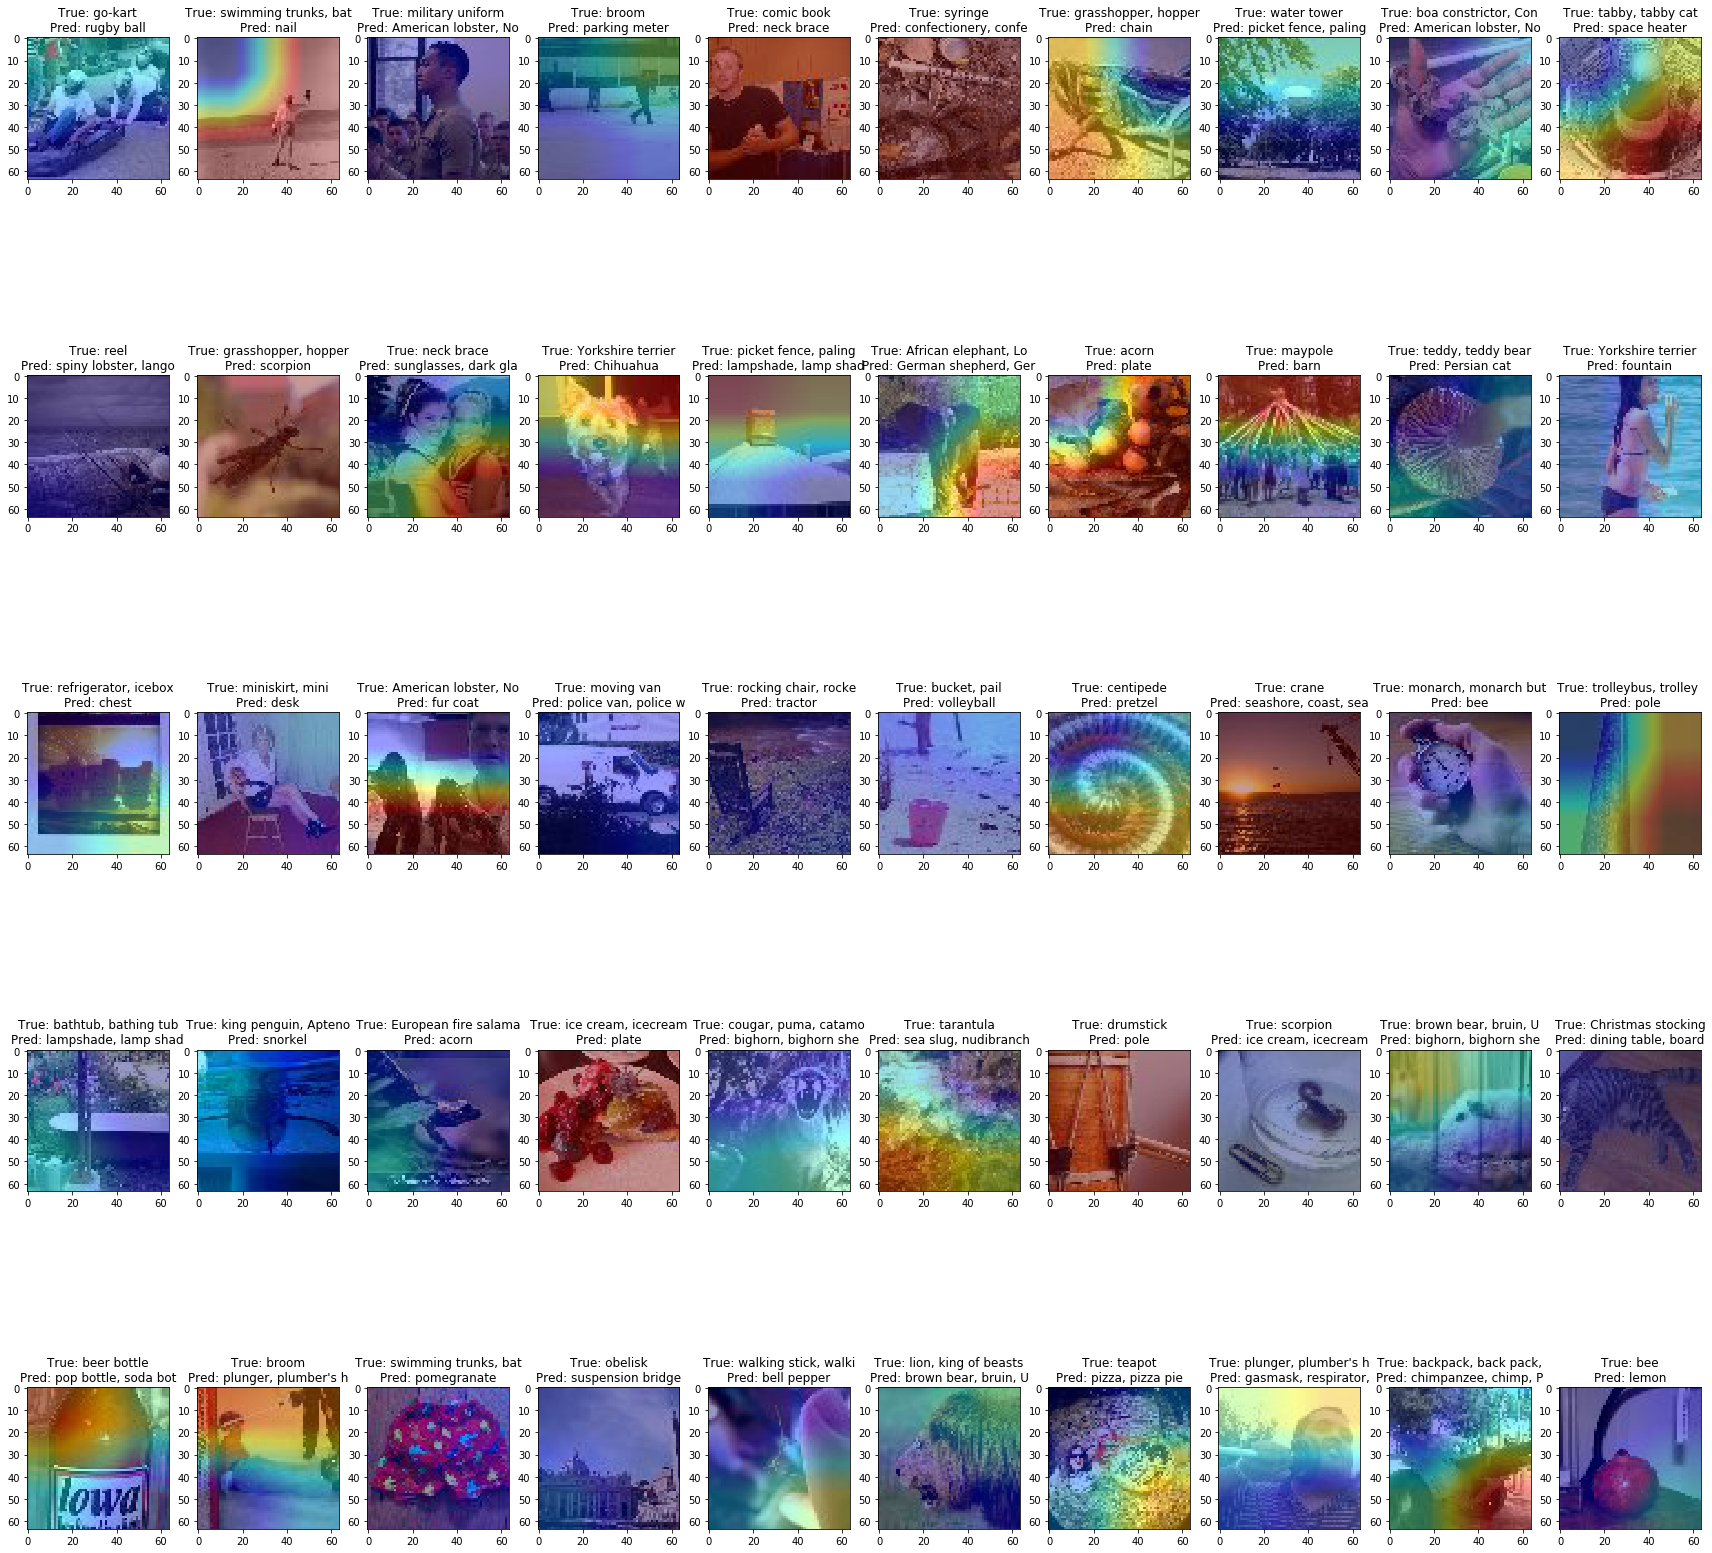

In [18]:
plot_x = 5
plot_y = 10
fig, ax = plt.subplots(plot_x, plot_y, figsize = (30, 30))

for i in range(plot_y):
  for j in range(plot_x):
    idx = i*plot_x + j
    val_idx = wrong_idxs[idx]
    
    true_class = my_labels[validation_generator.labels[val_idx]][:20]
    pred_class = my_labels[predicted_classes[val_idx]][:20]
    ax[j, i].imshow(superimposed_imgs[idx])
    ax[j, i].set_title('True: {}\nPred: {}'.format(str(true_class), str(pred_class)))